In [49]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import pandas as pd
%matplotlib inline

In [50]:
def make_simple_sample_data_2d_peanut(data_type = "iris"):
    from iris.cube import Cube
    from iris.coords import DimCoord, AuxCoord

    t_0 = datetime.datetime(2000, 1, 1, 12, 0, 0)

    x = np.arange(0, 100000, 1000)
    y = np.arange(0, 100000, 1000)
    t = t_0 + np.arange(0, 100, 1) * datetime.timedelta(minutes=1)
    xx, yy = np.meshgrid(x, y)

    t_temp = np.arange(0, 60, 1)
    track1_t = t_0 + t_temp * datetime.timedelta(minutes=1)
    x_0_1 = 10000
    y_0_1 = 10000
    track1_x = x_0_1 + 30 * t_temp * 60
    track1_y = y_0_1 + 14 * t_temp * 60
    track1_magnitude = 10 * np.ones(track1_x.shape)
    
    t_temp = np.arange(0, 30, 1)
    track2_t = t_0 + (t_temp + 15) * datetime.timedelta(minutes=1)
    x_0_2 = 40000
    y_0_2 = 55000
    track2_x = x_0_2 + 28 * t_temp * 60
    track2_y = y_0_2 + 13 * t_temp * 60
    track2_magnitude = 10 * np.ones(track2_x.shape)

    data = np.zeros((t.shape[0], y.shape[0], x.shape[0]))
    for i_t, t_i in enumerate(t):
        if np.any(t_i in track1_t):
            x_i = track1_x[track1_t == t_i]
            y_i = track1_y[track1_t == t_i]
            mag_i = track1_magnitude[track1_t == t_i]
            data[i_t] = data[i_t] + mag_i * np.exp(-np.power(xx - x_i, 2.0) / (2 * np.power(10000, 2.0))) * np.exp(-np.power(yy - y_i, 2.0) / (2 * np.power(10000, 2.0)))
        if np.any(t_i in track2_t):
            x_i = track2_x[track2_t == t_i]
            y_i = track2_y[track2_t == t_i]
            mag_i = track2_magnitude[track2_t == t_i]
            data[i_t] = data[i_t] + mag_i * np.exp(-np.power(xx - x_i, 2.0) / (2 * np.power(10000, 2.0))) * np.exp(-np.power(yy - y_i, 2.0) / (2 * np.power(10000, 2.0)))

    t_start = datetime.datetime(1970, 1, 1, 0, 0)
    t_points = (t - t_start).astype("timedelta64[ms]").astype(int) / 1000
    t_coord = DimCoord(t_points, standard_name="time", var_name="time", units="seconds since 1970-01-01 00:00")
    x_coord = DimCoord(x, standard_name="projection_x_coordinate", var_name="x", units="m")
    y_coord = DimCoord(y, standard_name="projection_y_coordinate", var_name="y", units="m")
    lat_coord = AuxCoord(24 + 1e-5 * xx, standard_name="latitude", var_name="latitude", units="degree")
    lon_coord = AuxCoord(150 + 1e-5 * yy, standard_name="longitude", var_name="longitude", units="degree")
    sample_data = Cube(
        data,
        dim_coords_and_dims=[(t_coord, 0), (y_coord, 1), (x_coord, 2)],
        aux_coords_and_dims=[(lat_coord, (1, 2)), (lon_coord, (1, 2))],
        var_name="w",
        units="m s-1",
    )

    if data_type == "xarray":
        sample_data = xr.DataArray.from_iris(sample_data)

    return sample_data

In [51]:
def plot_data(section, mask, feat):
    section.isel(time=35).plot(x="x", y="y")
    contours_section = mask.isel(time=35).plot.contour(levels=[0.5], x="x", y="y", colors="white")
    features_frame = feat.loc[feat["frame"] == 35]
    for _, r in features_frame.iterrows():
        plt.plot(r["projection_x_coordinate"], r["projection_y_coordinate"], marker="x", ms=10, mew=3, color="white")

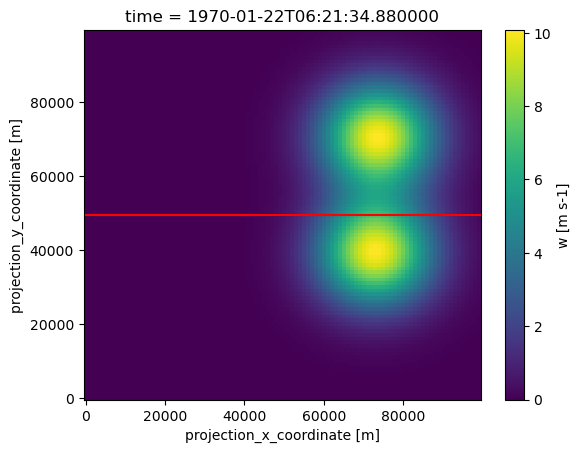

In [52]:
blob = make_simple_sample_data_2d_peanut()
dxy, dt = tobac.get_spacings(blob)
blob_xr = xr.DataArray.from_iris(blob).isel(time=35)

blob_xr.plot(x="x", y="y")
plt.axhline(y=blob_xr.y.max().item()/2, color='r', linestyle='-')

In [53]:
parameters_features = {'position_threshold': 'weighted_diff',
                       'sigma_threshold': 0.5,
                       'n_min_threshold': 5,
                       'target': 'maximum',
                       'threshold': [8]}

parameters_segmentation= {'target': 'maximum',
                          'method': 'watershed',
                          'threshold': 6}

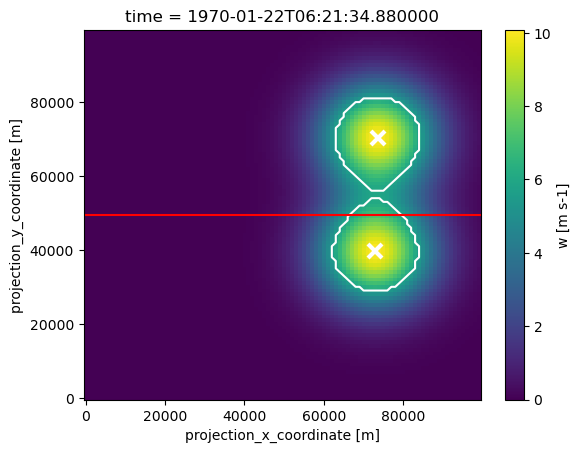

In [54]:
features = tobac.feature_detection_multithreshold(blob, dxy, **parameters_features)
frame = features.loc[features["frame"] == 35]

mask_seg, features_seg = tobac.segmentation_2D(features, blob, dxy, **parameters_segmentation)
mask_seg = xr.DataArray.from_iris(mask_seg)
blob_xr.plot(x="x", y="y")
contours = mask_seg.isel(time=35).plot.contour(levels=[0.5], x="x", y="y", colors="white")
plt.axhline(y=blob_xr.y.max().item()/2, color='r', linestyle='-')
for _, row in frame.iterrows():
    plt.plot(row["projection_x_coordinate"], row["projection_y_coordinate"], marker="x", ms=10, mew=3, color="white")

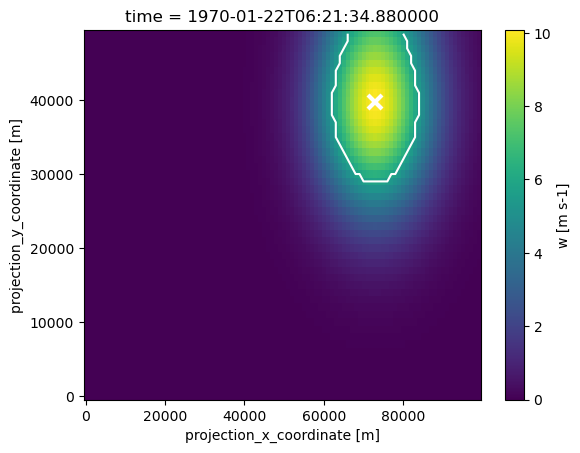

In [55]:
blob_section = xr.DataArray.from_iris(blob).isel(y=slice(0, int(blob_xr.sizes["y"]/2)))
features = tobac.feature_detection_multithreshold(blob_section.to_iris(), dxy, **parameters_features)
mask_seg, _ = tobac.segmentation_2D(features, blob_section.to_iris(), dxy, **parameters_segmentation)
mask_seg = xr.DataArray.from_iris(mask_seg)
plot_data(blob_section, mask_seg, features)

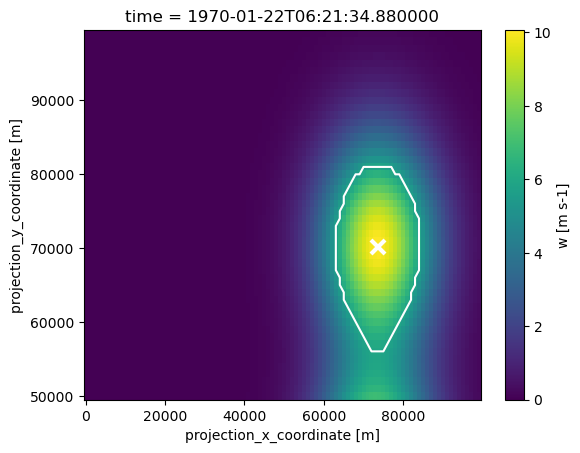

In [56]:
blob_section_ = xr.DataArray.from_iris(blob).isel(y=slice(int(blob_xr.sizes["y"]/2), int(blob_xr.sizes["y"])))
features_ = tobac.feature_detection_multithreshold(blob_section_.to_iris(), dxy, **parameters_features)
mask_seg_, _ = tobac.segmentation_2D(features_, blob_section_.to_iris(), dxy, **parameters_segmentation)
mask_seg_ = xr.DataArray.from_iris(mask_seg_)
plot_data(blob_section_, mask_seg_, features_)

In [57]:
mask_df_a = mask_seg.isel(time=35).to_pandas()
mask_df_a = mask_df_a.reindex(index=mask_df_a.index[::-1])

x = mask_df_a.head(1)
index_plus = x.index.item() + 1000
index_list = []
marker_dict = {}
feature = 0
for column in x:
    if mask_df_a[column].iloc[0] != 0:
        feature = mask_df_a[column].iloc[0]
        index_list.append(column)
    else:
        if index_list:
            marker_dict[feature] = round(np.mean(index_list))
            index_list = []
   
for f, m in marker_dict.items():
    feature_row = features.loc[features["feature"] == feature]
    feature_row.loc[:, "hdim_1"] = 0
    feature_row.loc[:, "hdim_2"] = m / 1000
    feature_row.loc[:, "projection_y_coordinate"] = index_plus
    feature_row.loc[:, "projection_x_coordinate"] = m

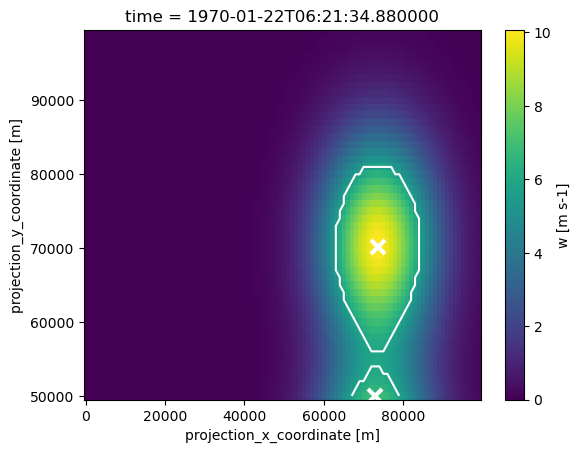

In [58]:
blob_section = xr.DataArray.from_iris(blob).isel(y=slice(int(blob_xr.sizes["y"]/2), int(blob_xr.sizes["y"])))
features = tobac.feature_detection_multithreshold(blob_section.to_iris(), dxy, **parameters_features)
features_c = pd.concat([features, feature_row])
features_c.sort_values(inplace=True, by=['frame'])
features_c.reset_index(inplace=True, drop=True)
mask_seg, features_seg = tobac.segmentation_2D(features_c, blob_section.to_iris(), dxy, **parameters_segmentation)
mask_seg = xr.DataArray.from_iris(mask_seg)
plot_data(blob_section, mask_seg, features_c)

In [61]:
mask_df_b = mask_seg.isel(time=35).to_pandas()
mask_df_b = mask_df_b.reindex(index=mask_df_b.index[::-1])

merged_mask = pd.concat([mask_df_b, mask_df_a])
    
for column in merged_mask:
    if merged_mask[column].iloc[int(blob_xr.sizes["y"]/2) - 1] != 0 and merged_mask[column].iloc[int(blob_xr.sizes["y"]/2)] != 0:
        merged_mask = merged_mask.replace(merged_mask[column].iloc[int(blob_xr.sizes["y"]/2) - 1], merged_mask[column].iloc[int(blob_xr.sizes["y"]/2)])